In [26]:
import qutip as qt 
#import qutip_jax
#import jax.numpy as jnp
#from jax import jit

Now on to the simulation, first the pseudomode bit

In [27]:
from scipy.integrate import quad
import matplotlib.pyplot as plt

In [28]:
import numpy as np

In [29]:
def _matsubara_zero_integrand(t, coup_strength, bath_broad, bath_freq):
    """
    Integral for the zero temperature Matsubara exponentials.
    """
    lam = coup_strength
    gamma = bath_broad
    w0 = bath_freq

    omega = np.sqrt(w0 ** 2 - (gamma / 2) ** 2)
    a = omega + 1j * gamma / 2.0
    aa = np.conjugate(a)

    prefactor = -(lam ** 2 * gamma) / np.pi
    integrand = lambda x: np.real(
        prefactor * ((x * np.exp(-x * t)) / ((a ** 2 + x ** 2) * (aa ** 2 + x ** 2)))
    )
    integrand2 = lambda x: np.imag(
        prefactor * ((x * np.exp(-x * t)) / ((a ** 2 + x ** 2) * (aa ** 2 + x ** 2)))
    )

    return quad(integrand, 0.0, np.inf)[0]+1j*quad(integrand2, 0.0, np.inf)[0]

In [30]:
t=np.linspace(0,50,500)
lam=0.5
gamma=0.1
w0=1
C=np.array([_matsubara_zero_integrand(i,lam,gamma,w0) for i in t])

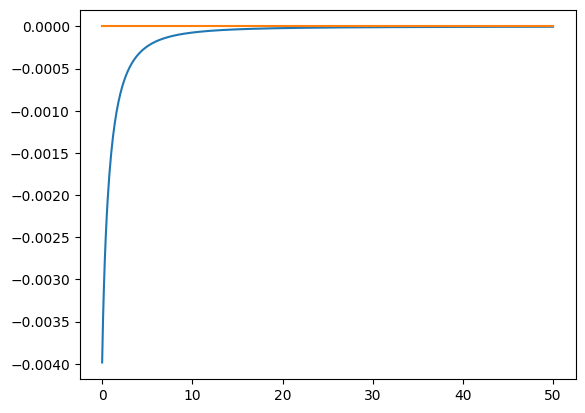

In [31]:
plt.plot(t,np.real(C))
plt.plot(t,np.imag(C))

In [32]:
help(qt.solver.heom.CorrelationFitter)

Help on class CorrelationFitter in module qutip.solver.heom.bofin_fit:

class CorrelationFitter(builtins.object)
 |  CorrelationFitter(Q, T, t, C)
 |
 |  A helper class for constructing a Bosonic bath from a fit of the
 |  correlation function with exponential terms.
 |
 |  Parameters
 |  ----------
 |  Q : :obj:`.Qobj`
 |      Operator describing the coupling between system and bath.
 |  T : float
 |      Temperature of the bath.
 |  t : :obj:`np.array.`
 |      The range which to perform the fit.
 |  C : :obj:`np.array.` or callable
 |      The correlation function to be fitted as an array or function.
 |
 |  Methods defined here:
 |
 |  __init__(self, Q, T, t, C)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |
 |  get_fit(self, Nr=None, Ni=None, final_rmse=2e-05, lower=None, upper=None, sigma=None, guesses=None, full_ansatz=False)
 |      Fit the correlation function with Ni exponential terms
 |      for the imaginary part of the correlation function and Nr

In [33]:
cfiitter=qt.solver.heom.CorrelationFitter(qt.sigmax(),1,t,C)

In [34]:
fit=cfiitter.get_fit(Ni=1,Nr=1)

In [35]:
print(fit[1]['summary']) #notice one mode is also a pretty good approximation

Fit correlation class instance: 
 
Result of fitting The Real Part Of                                      |Result of fitting The Imaginary Part                                    
 the Correlation Function with 1 terms:                                 | Of the Correlation Function with 1 terms:                              
                                                                        |                                                                        
 Parameters|    a     |    b     |    c                                 | Parameters|    a     |    b     |    c                                 
 1         |-3.44e-03 |-7.07e-01 |3.72e-19                              | 1         | 0.00e+00 | 0.00e+00 |0.00e+00                              
                                                                        |                                                                        
A  normalized RMSE of  6.69e-04 was obtained for the The Real Part Of   |A  normalized RM

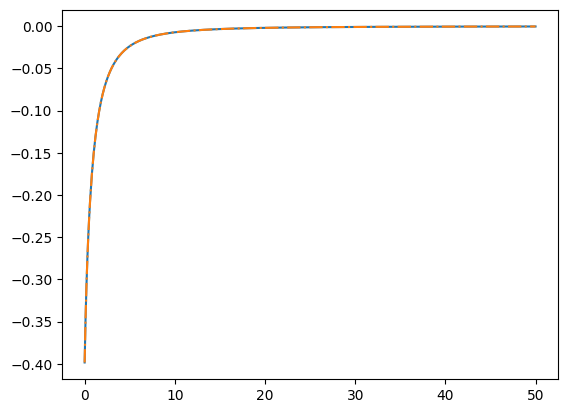

In [36]:
plt.plot(t,100*np.real(fit[0].correlation_function(t)))
plt.plot(t,100*np.real(C),'-.')

continue according to https://arxiv.org/pdf/1903.05892

In [37]:
def C0(t,coupling,gamma,w0,beta=np.inf):
    Gamma= gamma/2
    Omega= np.sqrt(w0**2 -Gamma**2)
    tempc0r= (1/np.tanh(beta*(Omega+ Gamma*1j)/2))*np.exp(1j*Omega*t)
    c0r=tempc0r+np.conjugate(tempc0r)
    c0i= -2j*np.sin(Omega*t)
    return (c0r+c0i)*(coupling**2)/(4*Omega)*np.exp(-Gamma*t)

In [38]:
help(qt.heom.UnderDampedBath)

Help on class UnderDampedBath in module qutip.solver.heom.bofin_baths:

class UnderDampedBath(BosonicBath)
 |  UnderDampedBath(Q, lam, gamma, w0, T, Nk, combine=True, tag=None)
 |
 |  A helper class for constructing an under-damped bosonic bath from the
 |  bath parameters (see parameters below).
 |
 |  Parameters
 |  ----------
 |  Q : Qobj
 |      Operator describing the coupling between system and bath.
 |
 |  lam : float
 |      Coupling strength.
 |
 |  gamma : float
 |      Bath spectral density cutoff frequency.
 |
 |  w0 : float
 |      Bath spectral density resonance frequency.
 |
 |  T : float
 |      Bath temperature.
 |
 |  Nk : int
 |      Number of exponential terms used to approximate the bath correlation
 |      functions.
 |
 |  combine : bool, default True
 |      Whether to combine exponents with the same frequency (and coupling
 |      operator). See :meth:`BosonicBath.combine` for details.
 |
 |  tag : optional, str, tuple or any other object
 |      A label for th

In [39]:
bath=qt.heom.UnderDampedBath(qt.sigmaz(),lam,gamma,w0,1e-18,5) # functions don't take zero because 1/T should be fixed

/tmp/ipykernel_2955/96333778.py:4: RuntimeWarning: invalid value encountered in scalar divide
  tempc0r= (1/np.tanh(beta*(Omega+ Gamma*1j)/2))*np.exp(1j*Omega*t)


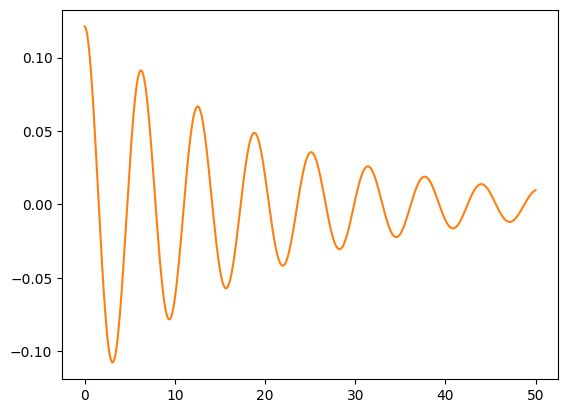

In [40]:
plt.plot(t,np.real(C0(t,lam,gamma,w0)+np.real(fit[0].correlation_function(t))))
plt.plot(t,np.real(bath.correlation_function(t)))
plt.show()

/tmp/ipykernel_2955/96333778.py:4: RuntimeWarning: invalid value encountered in scalar divide
  tempc0r= (1/np.tanh(beta*(Omega+ Gamma*1j)/2))*np.exp(1j*Omega*t)


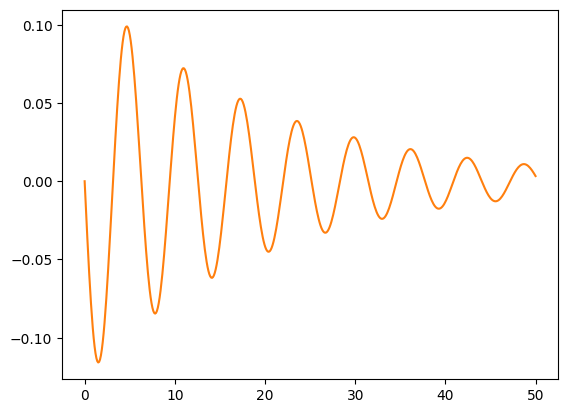

In [41]:
plt.plot(t,np.imag(C0(t,lam,gamma,w0)+np.real(fit[0].correlation_function(t))))
plt.plot(t,np.imag(bath.correlation_function(t)))
plt.show()

# Now I just need to construct my pseudomodes according to 

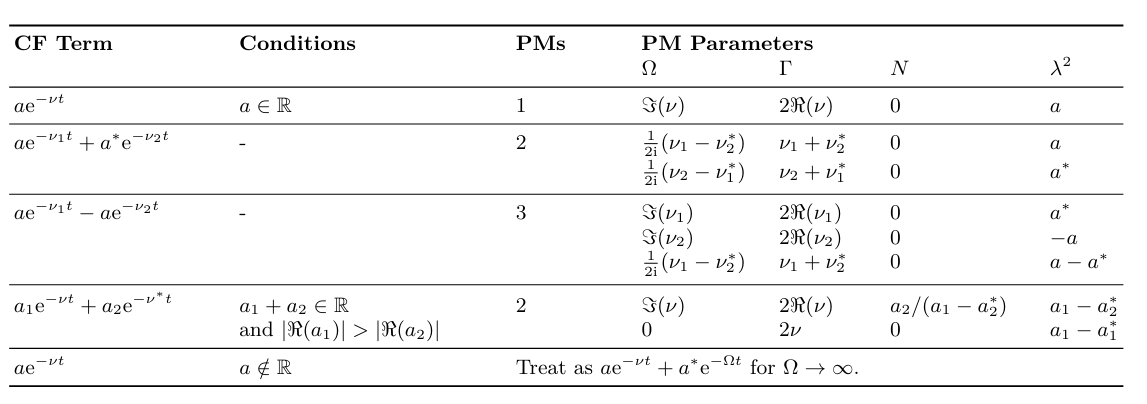

In [42]:
from IPython.display import display, Markdown
display(Markdown("# In my case I have two exponentials: given by \n -Non-Matsubara \n $a=\\frac{\lambda^{2}}{2 \Omega}$ and $\\nu=(\Gamma+i\Omega)t$ \n - Matsubara "
                 f"a={fit[1]['params_real'][0][0]:2e} and" rf" $\nu$={fit[1]['params_real'][1][0]+1j*fit[1]['params_real'][2][0]:2e}") )

<>:2: SyntaxWarning: invalid escape sequence '\l'
<>:2: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_2955/2649313208.py:2: SyntaxWarning: invalid escape sequence '\l'
  display(Markdown("# In my case I have two exponentials: given by \n -Non-Matsubara \n $a=\\frac{\lambda^{2}}{2 \Omega}$ and $\\nu=(\Gamma+i\Omega)t$ \n - Matsubara "


# In my case I have two exponentials: given by 
 -Non-Matsubara 
 $a=\frac{\lambda^{2}}{2 \Omega}$ and $\nu=(\Gamma+i\Omega)t$ 
 - Matsubara a=-3.440466e-03 and $\nu$=-7.072923e-01+3.722829e-19j

So i can get away with two pseudomodes, as both as are real 

# I can assume the exponent to be real and therefore energy of that mode to be 0

In [43]:
cutoff=2
def tensor_id(op,pos,cutoff=cutoff):
    if pos==0:
        return qt.tensor([op,qt.qeye(cutoff),qt.qeye(cutoff)])
    if pos==1:
        return qt.tensor([qt.qeye(2),op,qt.qeye(cutoff),])
    else:
        return qt.tensor([qt.qeye(2),qt.qeye(cutoff),op])
Gamma= gamma/2
Omega= np.sqrt(w0**2 -Gamma**2)
Hsys=tensor_id(0*qt.sigmaz()/2 + qt.sigmax()/2 ,0)
Q=tensor_id(qt.sigmaz(),0)
a=tensor_id(qt.destroy(cutoff),1)
b=tensor_id(qt.destroy(cutoff),2)
Hpm= Omega*a.dag()*a+fit[1]['params_real'][2][0]*b.dag()*b
Hsys_pm=np.sqrt((lam**2/(2*Omega)))*Q*(a+a.dag())+np.sqrt(fit[1]['params_real'][0][0]+0j)*Q*(b+b.dag())
H=Hsys+Hsys_pm+Hpm

Now I just simulate with mesolve

In [44]:
tlist = np.linspace(0, 250, 1000)

In [45]:
initial_ket = qt.basis(2, 1)
psi0 = qt.tensor(initial_ket, qt.basis(cutoff,0), qt.basis(cutoff,0))

In [46]:
fit[1]['params_real'][1][0]

-0.7072923005122079

In [47]:
c_ops = [np.sqrt(gamma)*a, np.sqrt(fit[1]['params_real'][1][0]+0j)*b]
e_ops = [tensor_id(qt.sigmaz(),0)]


In [48]:
pseudomode= qt.mesolve(H, psi0, tlist, c_ops, e_ops)
outputpm = (pseudomode.expect[0] + 1)/2


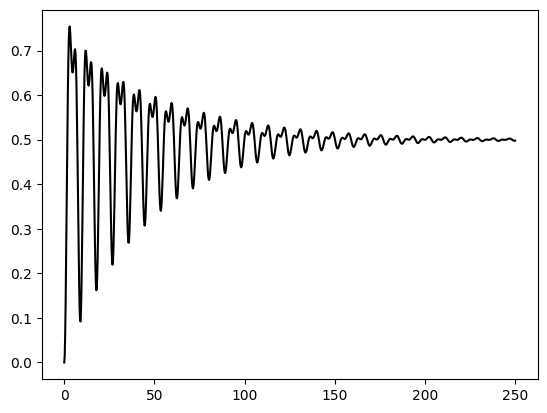

In [49]:
plt.plot(tlist, outputpm, color="k")
#plt.plot(tlist, sdd,"-.", color="r")
plt.show()

Cross-check agaisnt HEOM

In [50]:
cfiitter2=qt.solver.heom.CorrelationFitter(qt.sigmaz(),0,t,bath.correlation_function)

In [51]:
fit2=cfiitter2.get_fit(Ni=1,Nr=2)

/tmp/ipykernel_2955/96333778.py:4: RuntimeWarning: invalid value encountered in scalar divide
  tempc0r= (1/np.tanh(beta*(Omega+ Gamma*1j)/2))*np.exp(1j*Omega*t)


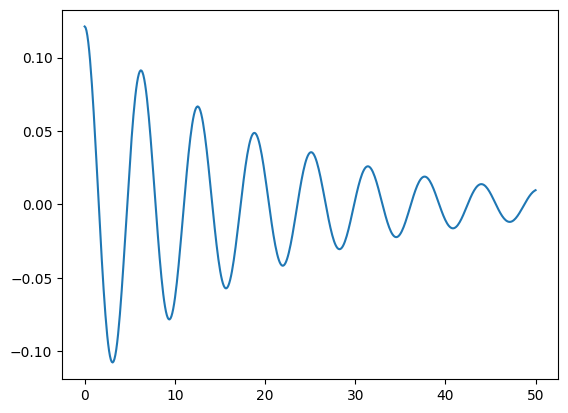

In [52]:
plt.plot(t,np.real(bath.correlation_function(t)))
plt.plot(t,np.real(C0(t,lam,gamma,w0))+np.real(fit[0].correlation_function(t)))

plt.show()

In [53]:
print(fit2[1]['summary']) #notice one mode is also a pretty good approximation

Fit correlation class instance: 
 
Result of fitting The Real Part Of                                      |Result of fitting The Imaginary Part                                    
 the Correlation Function with 2 terms:                                 | Of the Correlation Function with 1 terms:                              
                                                                        |                                                                        
 Parameters|    a     |    b     |    c                                 | Parameters|    a     |    b     |    c                                 
 1         | 1.25e-01 |-5.00e-02 |9.99e-01                              | 1         |-1.25e-01 |-5.00e-02 |9.99e-01                              
 2         |-3.49e-03 |-7.21e-01 |5.02e-24                              |                                                                        
                                                                        |A  normalized RM

/tmp/ipykernel_2955/96333778.py:4: RuntimeWarning: invalid value encountered in scalar divide
  tempc0r= (1/np.tanh(beta*(Omega+ Gamma*1j)/2))*np.exp(1j*Omega*t)


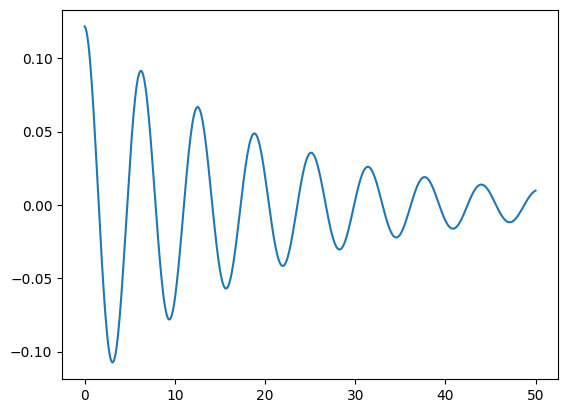

In [54]:
plt.plot(t,np.real(fit2[0].correlation_function_approx(t)))
plt.plot(t,np.real(C0(t,lam,gamma,w0))+np.real(fit[0].correlation_function_approx(t)))

plt.show()

In [55]:
solver = qt.heom.HEOMSolver(0*qt.sigmaz()/2+qt.sigmax()/2,
                    [fit2[0]], max_depth=7)
result = solver.run(initial_ket*initial_ket.dag(), tlist)

10.0%. Run time:   0.35s. Est. time left: 00:00:00:03
20.0%. Run time:   0.70s. Est. time left: 00:00:00:02
30.0%. Run time:   1.05s. Est. time left: 00:00:00:02
40.0%. Run time:   1.39s. Est. time left: 00:00:00:02
50.1%. Run time:   1.72s. Est. time left: 00:00:00:01
60.1%. Run time:   2.06s. Est. time left: 00:00:00:01
70.1%. Run time:   2.39s. Est. time left: 00:00:00:01
80.1%. Run time:   2.70s. Est. time left: 00:00:00:00
90.1%. Run time:   3.03s. Est. time left: 00:00:00:00
100.0%. Run time:   3.41s. Est. time left: 00:00:00:00
Total run time:   3.41s


In [56]:
sdd=[i[0,0] for i in result.states]

/home/mcditoos/anaconda3/envs/qutip-dev/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/mcditoos/anaconda3/envs/qutip-dev/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


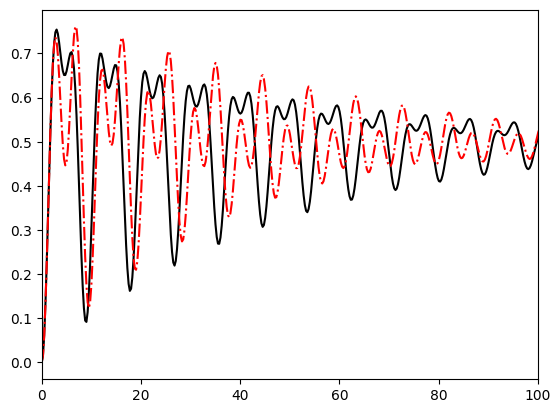

In [57]:
plt.plot(tlist, outputpm, color="k")
plt.plot(tlist, sdd,"-.", color="r")
plt.xlim(0,100)
plt.show()# Add master equations to the miz and show this ones in your thesis

In [71]:
from qutip import tensor,qeye,destroy,sigmaz,sigmax,sigmay,mesolve,basis,heom
import numpy as np
import matplotlib.pyplot as plt
from qutip.solver.heom import BathExponent

class pseudomode:
    def __init__(self,Hsys,Q,bath):
        self.Hsys=Hsys
        self.Q=Q
        self.bath=bath
        self.coefficients()
    def coefficients(self):
        cks=np.zeros(len(self.bath.exponents)//2,dtype=np.complex128)
        vks=np.zeros(len(self.bath.exponents)//2,dtype=np.complex128)
        seen=set()
        i=0
        for exp in self.bath.exponents:
            if exp.vk not in seen:
                if exp.type ==BathExponent.types["R"]:
                    cks[i]=exp.ck 
                else:
                    cks[i]=-1j*exp.ck
                vks[i]=-exp.vk
                seen.add(exp.vk.conjugate())
                i=i+1
        self.cks=cks
        self.vks=vks
    def tensor_id(self,pos,cutoff=2,op=None):
        temp=[qeye(cutoff)]*(len(self.cks)+1)
        if pos!=0:
            temp[0]=qeye(self.Hsys.shape[0])
            temp[pos]=destroy(cutoff)
        else:
            temp[0]=op
        return tensor(temp)
    def hamiltonian(self,cutoff=2):
        Hsys=self.tensor_id(0,cutoff,self.Hsys)
        Q=self.tensor_id(0,cutoff,self.Q)
        destroys=[self.tensor_id(i+1,cutoff) for i in range(len(self.cks))]
        for i in destroys:
            i.dims=Hsys.dims
        Hpm=sum([np.sqrt(np.imag(i)+0j)*destroys[k].dag()*destroys[k] for k,i in enumerate(self.vks) ])
        Hsys_pm=sum([np.sqrt(i)*(destroys[k].dag()+destroys[k])*Q for k,i in enumerate(self.cks) ])
        Heff=Hsys+Hsys_pm+Hpm
        return Heff,destroys
    def power_spectrum(self,w):
        S=0
        for i in range(len(self.cks)):
            S += 2 * np.real(self.cks[i] / (self.vks[i] - 1j*w))
        return S
    def prepare(self,cutoff,initial):
        init=[initial]+[basis(cutoff,0)]*(len(self.cks))
        psi02 = tensor(init)
        psi02=psi02*psi02.dag()
        return psi02.to("CSR")
    
    def evolution(self,initial,cutoff,t,e_ops=[]):
        Heff,d=self.hamiltonian(cutoff)
        initial=self.prepare(cutoff,initial)
        e_ops=[self.tensor_id(0,cutoff,i) for i in e_ops]
        c_ops =[np.sqrt(2*np.real(i) +0j)*d[k] for k,i in enumerate(self.vks) ]
        return mesolve(Heff, initial, t, c_ops, e_ops)

In [72]:
example=pseudomode(Hsys=qt.sigmax()/2, Q=qt.sigmaz(),bath=fit2[0])

In [73]:
ans=example.evolution(initial_ket,3,tlist,e_ops=[sigmaz()])
outputpm2 = (ans.expect[0] + 1)/2


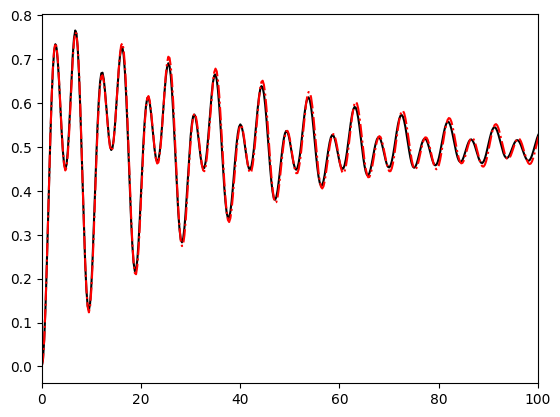

In [74]:
plt.plot(tlist, outputpm2, color="k")
plt.plot(tlist, sdd,"-.", color="r")
plt.xlim(0,100)
plt.show()# Add

In [75]:
example.bath.exponents

[<BathExponent type=R dim=None Q.dims=[[2], [2]] ck=(0.06259181202683872+0j) vk=(0.05001184927937835-0.9987440517233374j) ck2=None sigma_bar_k_offset=None fermionic=False tag=None>,
 <BathExponent type=R dim=None Q.dims=[[2], [2]] ck=(-0.0017454926245397216+0j) vk=(0.7207711480716872-5.024971806149644e-24j) ck2=None sigma_bar_k_offset=None fermionic=False tag=None>,
 <BathExponent type=R dim=None Q.dims=[[2], [2]] ck=(0.06259181202683872-0j) vk=(0.05001184927937835+0.9987440517233374j) ck2=None sigma_bar_k_offset=None fermionic=False tag=None>,
 <BathExponent type=R dim=None Q.dims=[[2], [2]] ck=(-0.0017454926245397216-0j) vk=(0.7207711480716872+5.024971806149644e-24j) ck2=None sigma_bar_k_offset=None fermionic=False tag=None>,
 <BathExponent type=I dim=None Q.dims=[[2], [2]] ck=0.0625782717900006j vk=(0.04999999999972594-0.9987492177720316j) ck2=None sigma_bar_k_offset=None fermionic=False tag=None>,
 <BathExponent type=I dim=None Q.dims=[[2], [2]] ck=-0.0625782717900006j vk=(0.049999

In [76]:
np.sqrt(example.cks)

array([0.25018356+0.j        , 0.        +0.04177909j,
       0.25015649-0.j        ])